# Turkish Wikipedia, dot model, $\ell_2$-regularized

- dataset: `trwiki`
- model: _dot_
- optimizer: _SGD with decaying learning rate_
- regularization: $\ell_2$

The hyperparameters were found using the `trwiki-[...]-hyperparams` notebooks.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf

from datetime import datetime
from sklearn.metrics import (
    precision_recall_curve, average_precision_score)
from interank import wikiutils
from interank.models import DotModel
from interank.wikidata import WikiData

%matplotlib inline

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Loading the dataset

In [3]:
%%time
dataset = WikiData("/data/datasets/trwiki")

train_data = dataset.get_train_data()
test_data = dataset.get_test_data()

print("=========")
print("Training set: {} edits".format(len(train_data[0])))
print("Test set: {} edits".format(len(test_data[0])))
print("Number of users: {}".format(dataset.n_users))
print("Number of articles: {}".format(dataset.n_articles))
print("=========")

Training set: 7882291 edits
Test set: 532087 edits
Number of users: 1393027
Number of articles: 541476
CPU times: user 18.6 s, sys: 1.2 s, total: 19.8 s
Wall time: 19.1 s


## Setting up the model

- batch size: $5000$
- latent dimensions: $20$
- initial learning rate: $0.1$
- decay rate: $0.9$
- regularization for skills and difficulties: $4.0$
- regularization for latent vectors: $160.0$

The model also includes a global bias, which is not regularized and has a distinct learning rate ($10^{-4}$, decay rate $0.7$).

In [4]:
# Reset graph to run the notebook twice in a row without error.
tf.reset_default_graph()

model = DotModel(
    n_users=dataset.n_users, n_articles=dataset.n_articles,
    n_dims=20, global_bias=True)

# Setup the optimisation procedure
batch_size = 5000
n_batches = math.ceil(len(train_data[0]) / batch_size)
print("Total number of batches: {}".format(n_batches))

# Setup train op.
cost = (-model.log_likelihood
            + (4.0/n_batches) * (model.l2_difficulty + model.l2_skill)
            + (160.0/n_batches) * (model.l2_vec_user + model.l2_vec_article))

# SGD with decaying learning rate.
learning_rate = 0.1
batch_idx_params = tf.Variable(0, trainable=False)
learning_rate_params = tf.train.exponential_decay(
    learning_rate=learning_rate,
    global_step=(batch_idx_params * batch_size),
    decay_steps=len(train_data[0]),
    decay_rate=0.9,
    staircase=True
)
batch_idx_bias = tf.Variable(0, trainable=False)
learning_rate_bias = tf.train.exponential_decay(
    learning_rate=1e-4,
    global_step=(batch_idx_bias * batch_size),
    decay_steps=len(train_data[0]),
    decay_rate=0.9,
    staircase=True
)
train_params = tf.train.GradientDescentOptimizer(learning_rate_params).minimize(
        cost, global_step=batch_idx_params,
        var_list=[model.skill, model.difficulty, model.vec_user, model.vec_article])
train_bias = tf.train.GradientDescentOptimizer(learning_rate_bias).minimize(
        cost, global_step=batch_idx_bias,
        var_list=[model.global_bias])
train_op = tf.group(train_params, train_bias)

# Summaries for Tensorboard
auc_ph = tf.placeholder(tf.float32, name="auc")
tf.summary.scalar("avg_log_loss", model.avg_log_loss)
tf.summary.scalar("area_under_pr_curve", auc_ph)
merged = tf.summary.merge_all()

logdir = '../trained-models/tmp'
folder = "trwiki-dot-regularized_batchsize={}_lr={}_date={}".format(
        batch_size, learning_rate, datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
writer = {
    "train": tf.summary.FileWriter(os.path.join(logdir, folder, "train")),
    "test": tf.summary.FileWriter(os.path.join(logdir, folder, "test")),
}

Total number of batches: 1577


In [5]:
step = 0

feed = {
    "train": {
        model.user_id: train_data[0],
        model.article_id: train_data[1],
        model.quality: train_data[2],
    },
    "test": {
        model.user_id: test_data[0],
        model.article_id: test_data[1],
        model.quality: test_data[2],
    }
}

def evaluate_model(step, bad_edit_threshold=0.5):
    print("### step {}".format(step))
    for which in ("train", "test"):
        avg_log_loss, probs = session.run(
            [model.avg_log_loss, model.probability], feed_dict=feed[which])
        labels = (feed[which][model.quality] < bad_edit_threshold).astype(int)
        auc = average_precision_score(labels, 1 - probs)
        summary = session.run(merged, feed_dict={**feed[which], auc_ph: auc})
        writer[which].add_summary(summary, global_step=step)
        writer[which].flush()
        print("{} set: avg. log-loss = {:.6f}, AUC = {:.3f}".format(
                which, avg_log_loss, auc))

# Initialise Tensorflow's variables
session = tf.Session()
session.run(tf.global_variables_initializer())

# Evalute "empty" model.
evaluate_model(step=step)

### step 0
train set: avg. log-loss = 0.693147, AUC = 0.221
test set: avg. log-loss = 0.693147, AUC = 0.168


## Training the model

In [6]:
%%time
epochs = 15

with session.as_default():
    for i in range(epochs):
        for batch in WikiData.minibatches(train_data, batch_size):
            step += 1
            # Train the model on a batch.
            feed_dict = {
                model.user_id: batch[0],
                model.article_id: batch[1],
                model.quality: batch[2],
            }
            _ = session.run(train_op, feed_dict=feed_dict)


        evaluate_model(step=step)
        print("global bias: {:.3f}".format(model.global_bias.eval()))

### step 1577
train set: avg. log-loss = 0.512317, AUC = 0.566
test set: avg. log-loss = 0.434293, AUC = 0.485
global bias: 0.334
### step 3154
train set: avg. log-loss = 0.507394, AUC = 0.591
test set: avg. log-loss = 0.429260, AUC = 0.492
global bias: 0.318
### step 4731
train set: avg. log-loss = 0.504841, AUC = 0.605
test set: avg. log-loss = 0.430574, AUC = 0.493
global bias: 0.313
### step 6308
train set: avg. log-loss = 0.503671, AUC = 0.611
test set: avg. log-loss = 0.429231, AUC = 0.495
global bias: 0.308
### step 7885
train set: avg. log-loss = 0.502891, AUC = 0.616
test set: avg. log-loss = 0.433571, AUC = 0.492
global bias: 0.313
### step 9462
train set: avg. log-loss = 0.502334, AUC = 0.617
test set: avg. log-loss = 0.428044, AUC = 0.495
global bias: 0.305
### step 11039
train set: avg. log-loss = 0.502021, AUC = 0.620
test set: avg. log-loss = 0.431837, AUC = 0.493
global bias: 0.302
### step 12616
train set: avg. log-loss = 0.501697, AUC = 0.622
test set: avg. log-loss =

## Qualitative results

In [7]:
with session.as_default():
    skills = model.skill.eval()
    difficulties = model.difficulty.eval()
articles = dataset.get_articles()
users = dataset.get_users()

In [8]:
wikiutils.print_articles_summary(difficulties, articles, n=5)

### 5 most difficult articles:
 1 +1.628 Vladimir Lenin bibliyografyasÄ± (1133 edits, 54 users)
    https://tr.wikipedia.org/wiki/Vladimir%20Lenin%20bibliyografyas%C3%84%C2%B1
 2 +1.240 Mehmet GÃ¼leryÃ¼z (445 edits, 38 users)
    https://tr.wikipedia.org/wiki/Mehmet%20G%C3%83%C2%BClery%C3%83%C2%BCz
 3 +1.217 The Texas Chainsaw Massacre karakterleri listesi (344 edits, 56 users)
    https://tr.wikipedia.org/wiki/The%20Texas%20Chainsaw%20Massacre%20karakterleri%20listesi
 4 +1.188 Buffy the Vampire Slayer yan karakterleri listesi (174 edits, 37 users)
    https://tr.wikipedia.org/wiki/Buffy%20the%20Vampire%20Slayer%20yan%20karakterleri%20listesi
 5 +1.176 Voleybolda Olimpiyat madalyasÄ± kazananlar listesi (138 edits, 26 users)
    https://tr.wikipedia.org/wiki/Voleybolda%20Olimpiyat%20madalyas%C3%84%C2%B1%20kazananlar%20listesi

### 5 least difficult articles:
 1 -1.769 Augusto De Luca (148 edits, 26 users)
    https://tr.wikipedia.org/wiki/Augusto%20De%20Luca
 2 -1.509 Nha Trang (105 ed

In [9]:
wikiutils.print_users_summary(skills, users, n=5)

### 5 most skilled users:
 1 +2.848 Rotlink (790 edits, 723 articles)
    https://tr.wikipedia.org/wiki/User:Rotlink
 2 +2.702 MerlLinkBot (1085 edits, 1055 articles)
    https://tr.wikipedia.org/wiki/User:MerlLinkBot
 3 +2.637 Fabian RRRR (272 edits, 258 articles)
    https://tr.wikipedia.org/wiki/User:Fabian%20RRRR
 4 +2.615 Nihat Halici (5503 edits, 2034 articles)
    https://tr.wikipedia.org/wiki/User:Nihat%20Halici
 5 +2.602 Japan Football (6828 edits, 5217 articles)
    https://tr.wikipedia.org/wiki/User:Japan%20Football

### 5 least skilled users:
 1 -2.384 - (221 edits, 221 articles)
    https://tr.wikipedia.org/wiki/User:-
 2 -2.369 - (154 edits, 152 articles)
    https://tr.wikipedia.org/wiki/User:-
 3 -2.198 - (218 edits, 107 articles)
    https://tr.wikipedia.org/wiki/User:-
 4 -2.081 - (73 edits, 66 articles)
    https://tr.wikipedia.org/wiki/User:-
 5 -2.054 - (83 edits, 72 articles)
    https://tr.wikipedia.org/wiki/User:-


Text(0.5,1,'Histogram of article difficulties')

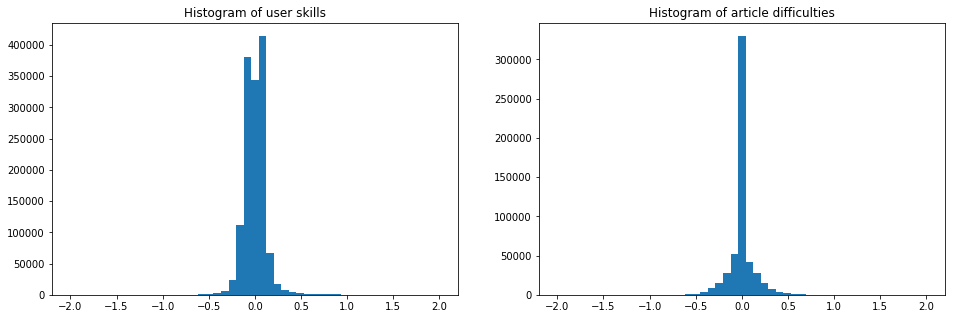

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5), sharex=True)

ax1.hist(skills, bins=np.linspace(-2, 2, num=50))
ax1.set_title("Histogram of user skills")

ax2.hist(difficulties, bins=np.linspace(-2, 2, num=50))
ax2.set_title("Histogram of article difficulties")

In [11]:
with session.as_default():
    probs = model.probability.eval(feed_dict=feed["test"])

Text(0.5,1,'Histogram of model estimates')

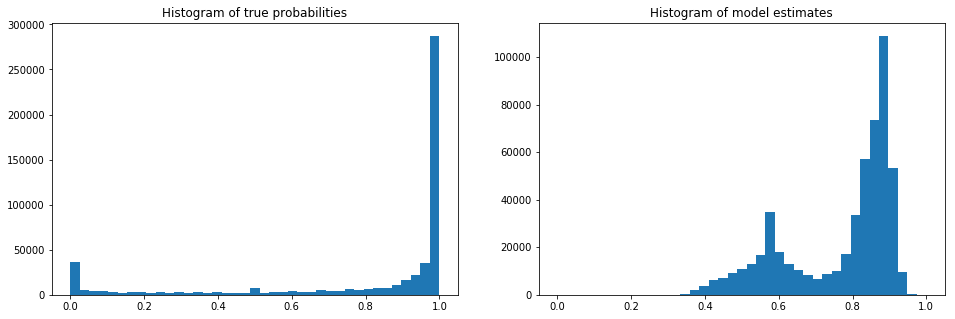

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5), sharex=True)

ax1.hist(test_data[2], bins=np.linspace(0, 1, num=40))
ax1.set_title("Histogram of true probabilities")

ax2.hist(probs, bins=np.linspace(0, 1, num=40))
ax2.set_title("Histogram of model estimates")

## Quantitative results

In [16]:
def avg_log_loss(y_true, y_pred):
    log_loss = - (y_true * np.log(y_pred)
            + (1 - y_true) * np.log(1 - y_pred))
    return log_loss.mean()


labels = (test_data[2] < 0.5).astype(int)
precision, recall, _ = precision_recall_curve(labels, 1 - probs)
auc = average_precision_score(labels, 1 - probs)

log_loss = avg_log_loss(labels, 1 - probs)
print(log_loss)

print("proportion of positive labels: {:.3f}".format(sum(labels) / len(labels)))

0.38113349128827756
proportion of positive labels: 0.168


Text(0.5,1,'Precision-recall curve (AUC: 0.496)')

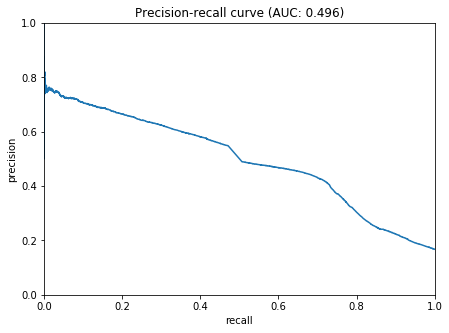

In [15]:
# New

fig, ax = plt.subplots(figsize=(7.0, 5.0))
ax.plot(recall, precision)
ax.set_xlim(xmin=0.0, xmax=1.0)
ax.set_ylim(ymin=0.0, ymax=1.0)
ax.set_ylabel("precision")
ax.set_xlabel("recall")
ax.set_title("Precision-recall curve (AUC: {:.3})".format(auc))

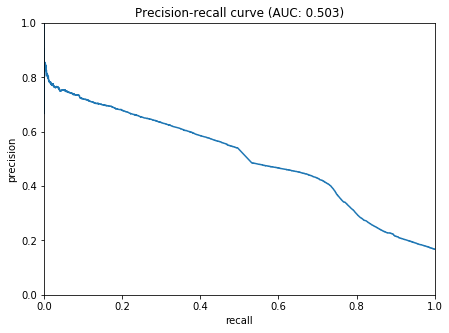

In [14]:
# Old

fig, ax = plt.subplots(figsize=(7.0, 5.0))
ax.plot(recall, precision)
ax.set_xlim(xmin=0.0, xmax=1.0)
ax.set_ylim(ymin=0.0, ymax=1.0)
ax.set_ylabel("precision")
ax.set_xlabel("recall")
ax.set_title("Precision-recall curve (AUC: {:.3})".format(auc))

## Save data for plotting, etc.

In [15]:
# Save TensorFlow model
saver = tf.train.Saver()
saver.save(session, "../trained-models/trwiki/dot.ckpt")

'../trained-models/trwiki/dot.ckpt'

In [17]:
data = {
    "y_true": test_data[2],
    "y_pred": probs,
}
with open("../data/trwiki-dot-pred.pickle", "wb") as f:
    pickle.dump(data, f)